# ACCESS-S2 sandbox

>9 June 2021<br>
>Thomas Moore

In [1]:
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import numpy as np
import xrft
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
%config Completer.use_jedi = False

In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Spin up a tiny little cluster with `dask-jobqueue`

### Specs for an individual worker

In [3]:
walltime = '01:00:00'
cores = 4
memory = '16GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/v14+scratch/v14+gdata/lp01+scratch/lp01+scratch/ux06+gdata/rr3+gdata/al33+gdata/zv2+gdata/ux62'],
                     header_skip=["select"])

### Scale up to n workers

In [4]:
cluster.scale(jobs=5)

In [5]:
client = Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.6.55.54:38653 Dashboard: http://10.6.55.54:8787/status,Cluster Workers: 20 Cores: 20 Memory: 74.60 GiB


# ACCESS-S2 ocean hindcasts
>Dates: mo_T_19810101_e01.nc - mo_T_20181231_e01.nc<br>
>Ensembles: 3? e01-3<br>
>8 month long forecasts?<br>
> 75 depth levels for T

In [17]:
root_path = '/g/data/ux62/access-s2/'
hindcast_ocean_path = '/g/data/ux62/access-s2/hindcast/raw_model/ocean/'
hindcast_ocean_varaibles_list = ['hc300','ssh','sss','sst','T']
hindcast_ocean_variables_standard_keys = ['integral_of_sea_water_potential_temperature_wrt_depth_expressed_as_heat_content',
                                          'sea_surface_height_above_geoid',
                                          ,'sst_sea_water_potential_temperature'
                                          'sea_water_potential_temperature']
hindcast_ocean_variables_long_keys = ['Heat content 300 m',
                                      'Sea Surface Height',
                                      'Temperature']

In [ ]:
hindcast_example = xr.open_dataset('/g/data/ux62/access-s2/hindcast/raw_model/ocean/T/monthly/e01/mo_T_20181231_e01.nc')
hindcast_example

In [18]:
hindcast_example = xr.open_dataset('/g/data/ux62/access-s2/hindcast/raw_model/ocean/sst/monthly/e01/mo_sst_20181231_e01.nc')
hindcast_example

<xarray.Dataset>
Dimensions:            (deptht: 1, ncorners: 4, ndepth_bounds: 2, tbnds: 2, time_counter: 9, x: 1442, y: 1021)
Coordinates:
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
  * deptht             (deptht) float32 0.5058
  * time_counter       (time_counter) datetime64[ns] 2019-01-16T12:00:00 ... ...
Dimensions without coordinates: ncorners, ndepth_bounds, tbnds, x, y
Data variables:
    lont_bounds        (y, x, ncorners) float32 ...
    latt_bounds        (y, x, ncorners) float32 ...
    areat              (y, x) float32 ...
    e1t                (y, x) float32 ...
    e2t                (y, x) float32 ...
    ang1t              (y, x) float32 ...
    deptht_bounds      (deptht, ndepth_bounds) float32 ...
    e3t                (deptht) float32 ...
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] ...
    temp               (time_counter, deptht, y, x) float32 ...
Attributes:
    Conventions:      CF-1.1
    production:       An IPSL model
    TimeStamp:        03/03/2021 02:22:39 -0000
    file_name:        cplhco.1d.mersea.grid_T.nc
    history:          Thu Mar  4 01:18:22 2021: ncks -O -F -a -v ang1t,e1t,e2...
    NCO:              "4.5.3"
    monthly_average:  Monthly file built with script ./process_missing_monthl...

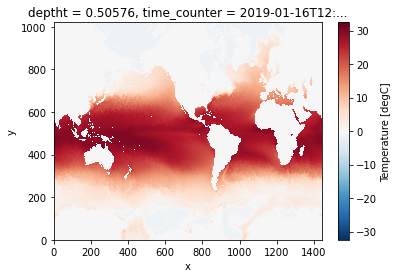

In [14]:
hindcast_example.temp.isel(deptht=0).isel(time_counter=0).plot()

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

In [ ]:
root_path = '/g/data/ux62/access-s2/'
RA_ocean_path = '/g/data/ux62/access-s2/reanalysis/ocean/'
RA_ocean_variables_list = ['blt','d20','emp','hc300','mld1','mld2','salt','ssh','sss','sst','swflx','td','temp','thflx','u','v','w']
RA_ocean_variables_standard_keys = ['barrier_layer_thickness',
                           'depth_of_20C_isotherm',
                           'water_flux_out_of_sea_ice_and_sea_water',
                           'integral_of_sea_water_potential_temperature_wrt_depth_expressed_as_heat_content',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_1',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_2',
                           'sea_water_salinity',
                           'sea_surface_height_above_geoid',
                           'surface_sea_water_salinity',
                           'sea_water_potential_temperature',
                           'downwelling_photosynthetic_radiative_flux_in_sea_water',
                           'depth_at_maximum_upward_derivative_of_sea_water_potential_temperature',
                           'sea_water_potential_temperature',
                           'surface_downward_heat_flux_in_sea_water',
                           'sea_water_x_velocity',
                           'sea_water_y_velocity',
                           'sea_water_z_velocity']
RA_ocean_variables_long_keys = ['Barrier Layer Thickness',
                                'Depth of 20C isotherm',
                                'Net Upward Water Flux',
                                'Heat content 300 m',
                                'Kara Mixed Layer Depth',
                                'Mixed Layer Depth 0.01',
                                'Salinity',
                                'Sea Surface Height',
                                'Sea Surface Salinity',
                                'Sea Surface Temperature',
                                'Shortwave Radiation',
                                'Thermocline Depth',
                                'Temperature',
                                'Net Downward Heat Flux',
                                'Zonal Current',
                                'Meridional Current',
                                'Vertical Velocity']
RA_ocean_variables_period_dict = {'daily':'do','monthly':'mo'}
RA_ocean_variables_standard_dict = dict(zip(RA_ocean_variables_standard_keys, RA_ocean_variables_list))
RA_ocean_variables_long_dict = dict(zip(RA_ocean_variables_long_keys, RA_ocean_variables_list))

In [ ]:
def make_ACCESS_S2_RA_path(period='monthly',variable_long_key ='Thermocline Depth'):
    RA_ocean_path = '/g/data/ux62/access-s2/reanalysis/ocean/'
    RA_ocean_variables_list = ['blt','d20','emp','hc300','mld1','mld2','salt','ssh','sss','sst','swflx','td','temp','thflx','u','v','w']
    RA_ocean_variables_standard_keys = ['barrier_layer_thickness',
                           'depth_of_20C_isotherm',
                           'water_flux_out_of_sea_ice_and_sea_water',
                           'integral_of_sea_water_potential_temperature_wrt_depth_expressed_as_heat_content',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_1',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_2',
                           'sea_water_salinity',
                           'sea_surface_height_above_geoid',
                           'surface_sea_water_salinity',
                           'sea_water_potential_temperature',
                           'downwelling_photosynthetic_radiative_flux_in_sea_water',
                           'depth_at_maximum_upward_derivative_of_sea_water_potential_temperature',
                           'sea_water_potential_temperature',
                           'surface_downward_heat_flux_in_sea_water',
                           'sea_water_x_velocity',
                           'sea_water_y_velocity',
                           'sea_water_z_velocity']
    RA_ocean_variables_long_keys = ['Barrier Layer Thickness',
                                'Depth of 20C isotherm',
                                'Net Upward Water Flux',
                                'Heat content 300 m',
                                'Kara Mixed Layer Depth',
                                'Mixed Layer Depth 0.01',
                                'Salinity',
                                'Sea Surface Height',
                                'Sea Surface Salinity',
                                'Sea Surface Temperature',
                                'Shortwave Radiation',
                                'Thermocline Depth',
                                'Temperature',
                                'Net Downward Heat Flux',
                                'Zonal Current',
                                'Meridional Current',
                                'Vertical Velocity']
    RA_ocean_variables_period_dict = {'daily':'do','monthly':'mo'}
    RA_ocean_variables_standard_dict = dict(zip(RA_ocean_variables_standard_keys, RA_ocean_variables_list))
    RA_ocean_variables_long_dict = dict(zip(RA_ocean_variables_long_keys, RA_ocean_variables_list))
    ACCESS_S2_RA_path = RA_ocean_path + RA_ocean_variables_long_dict[variable_long_key]+'/'+RA_ocean_variables_period_dict[period]+'_'+RA_ocean_variables_long_dict[variable_long_key]+'*'
    return ACCESS_S2_RA_path

In [ ]:
make_ACCESS_S2_RA_path()

In [ ]:
ds = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1988.nc')
ds

# Q: What is ACCESS-S2 grid size? A: ~ 1/4 degree

In [ ]:
ds.x

In [ ]:
ds.y

In [ ]:
ds.nav_lat.plot()

In [ ]:
ds.nav_lon.plot()

In [ ]:
ds.nav_lon.min()

In [ ]:
ds.nav_lat.min()

In [ ]:
ds.nav_lat.max()

In [ ]:
(ds.nav_lat.max() - ds.nav_lat.min())/ds.y.size

In [ ]:
(ds.nav_lon.max() - ds.nav_lon.min())/ds.x.size

In [ ]:
ds.td.max(dim='time_counter').plot()

In [ ]:
make_ACCESS_S2_RA_path()

In [ ]:
ds = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_19*.nc',parallel=True)
ds

In [ ]:
file_list =[]
regexp = re.compile('mo_td_(201[0-8]).nc')
ROOT_DIR ='/g/data/ux62/access-s2/reanalysis/ocean/td/'
for root, dirs, files in os.walk(ROOT_DIR):
    for file in files:
        if regexp.search(file):
            file_list.append(os.path.join(root, file))

file_list.sort()
file_list

In [ ]:
ds_2010_2018 = xr.open_mfdataset(file_list,parallel=True)
ds_2010_2018

In [ ]:
file_list =[]
regexp = re.compile('mo_td_(198[1-9]|199[0-9]|200[0-9]).nc')
ROOT_DIR ='/g/data/ux62/access-s2/reanalysis/ocean/td/'
for root, dirs, files in os.walk(ROOT_DIR):
    for file in files:
        if regexp.search(file):
            file_list.append(os.path.join(root, file))

file_list.sort()
file_list

In [ ]:
ds_1981_2009 = xr.open_mfdataset(file_list,parallel=True)
ds_1981_2009

In [ ]:
ds = xr.merge([ds_1981_2009,ds_2010_2018])

In [ ]:
make_ACCESS_S2_RA_path(variable_long_key ='Heat content 300 m')

In [ ]:
xr.open_mfdataset(make_ACCESS_S2_RA_path(variable_long_key ='Heat content 300 m'),parallel=True)